## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize

import warnings
warnings.filterwarnings('ignore')

## 1. Simulation Data

### 1.1 ERA5

#### 1.1.1 Data Options

In [3]:
run_data = 'era5'
variable = 'PRCP'
general_path = 'data'

# ensemble members
micro_options = [
     'LIN',
     'THOMPSON',
     'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [4]:
data_path

['data/era5_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.1.2 Open Data

In [5]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_era5 = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

In [6]:
dt_era5

<xarray.DataArray 'PRCP' (ens: 6, time: 24, south_north: 200, west_east: 200)>
dask.array<getitem, shape=(6, 24, 200, 200), dtype=float32, chunksize=(1, 24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   Total precipitation rate
    units:         mm h-1
    stagger:       
    pyproj_srs:    +proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 ...
    coordinates:   XLONG XLAT XTIME
    grid_mapping:  spatial_ref

#### 1.1.3 Define Members

In [7]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

#### 1.1.4 Ensemble Mean For Urban and Nourban

In [8]:
dt_era5_urban_ens = dt_era5.sel(ens=urban_members).mean(dim='ens')

In [9]:
dt_era5_urban_ens

<xarray.DataArray 'PRCP' (time: 24, south_north: 200, west_east: 200)>
dask.array<mean_agg-aggregate, shape=(24, 200, 200), dtype=float32, chunksize=(24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    spatial_ref  int64 0

### 1.2 GFS

#### 1.2.1 Data Options

In [10]:
run_data = 'gfs'
variable = 'PRCP'
general_path = 'data'

# ensemble members
micro_options = [
     'LIN',
     'THOMPSON',
     'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [11]:
data_path

['data/gfs_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.2.2 Open Data

In [12]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_gfs = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

In [13]:
dt_gfs

<xarray.DataArray 'PRCP' (ens: 6, time: 24, south_north: 200, west_east: 200)>
dask.array<getitem, shape=(6, 24, 200, 200), dtype=float32, chunksize=(1, 24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   Total precipitation rate
    units:         mm h-1
    stagger:       
    pyproj_srs:    +proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 ...
    coordinates:   XLONG XLAT XTIME
    grid_mapping:  spatial_ref

#### 1.2.3 Ensemble Mean For Urban and Nourban

In [14]:
dt_gfs_urban_ens = dt_gfs.sel(ens=urban_members).mean(dim='ens')

In [15]:
dt_gfs_urban_ens

<xarray.DataArray 'PRCP' (time: 24, south_north: 200, west_east: 200)>
dask.array<mean_agg-aggregate, shape=(24, 200, 200), dtype=float32, chunksize=(24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    spatial_ref  int64 0

## 2. IMERG Data

In [16]:
# define general path to datasets
data_source = 'imerg'
imerg_var = 'IRprecipitation'
general_path = f'data/observation/{data_source}/*20170718*'

# get individual data links
data_links = glob(general_path)
imerg = xr.open_mfdataset(data_links)

# adjust imerg units and turn it from 30 mins interval to 1 hour sums
imerg = imerg.resample(time = '1H').sum()[imerg_var]
imerg = imerg.transpose('time', 'lat', 'lon')

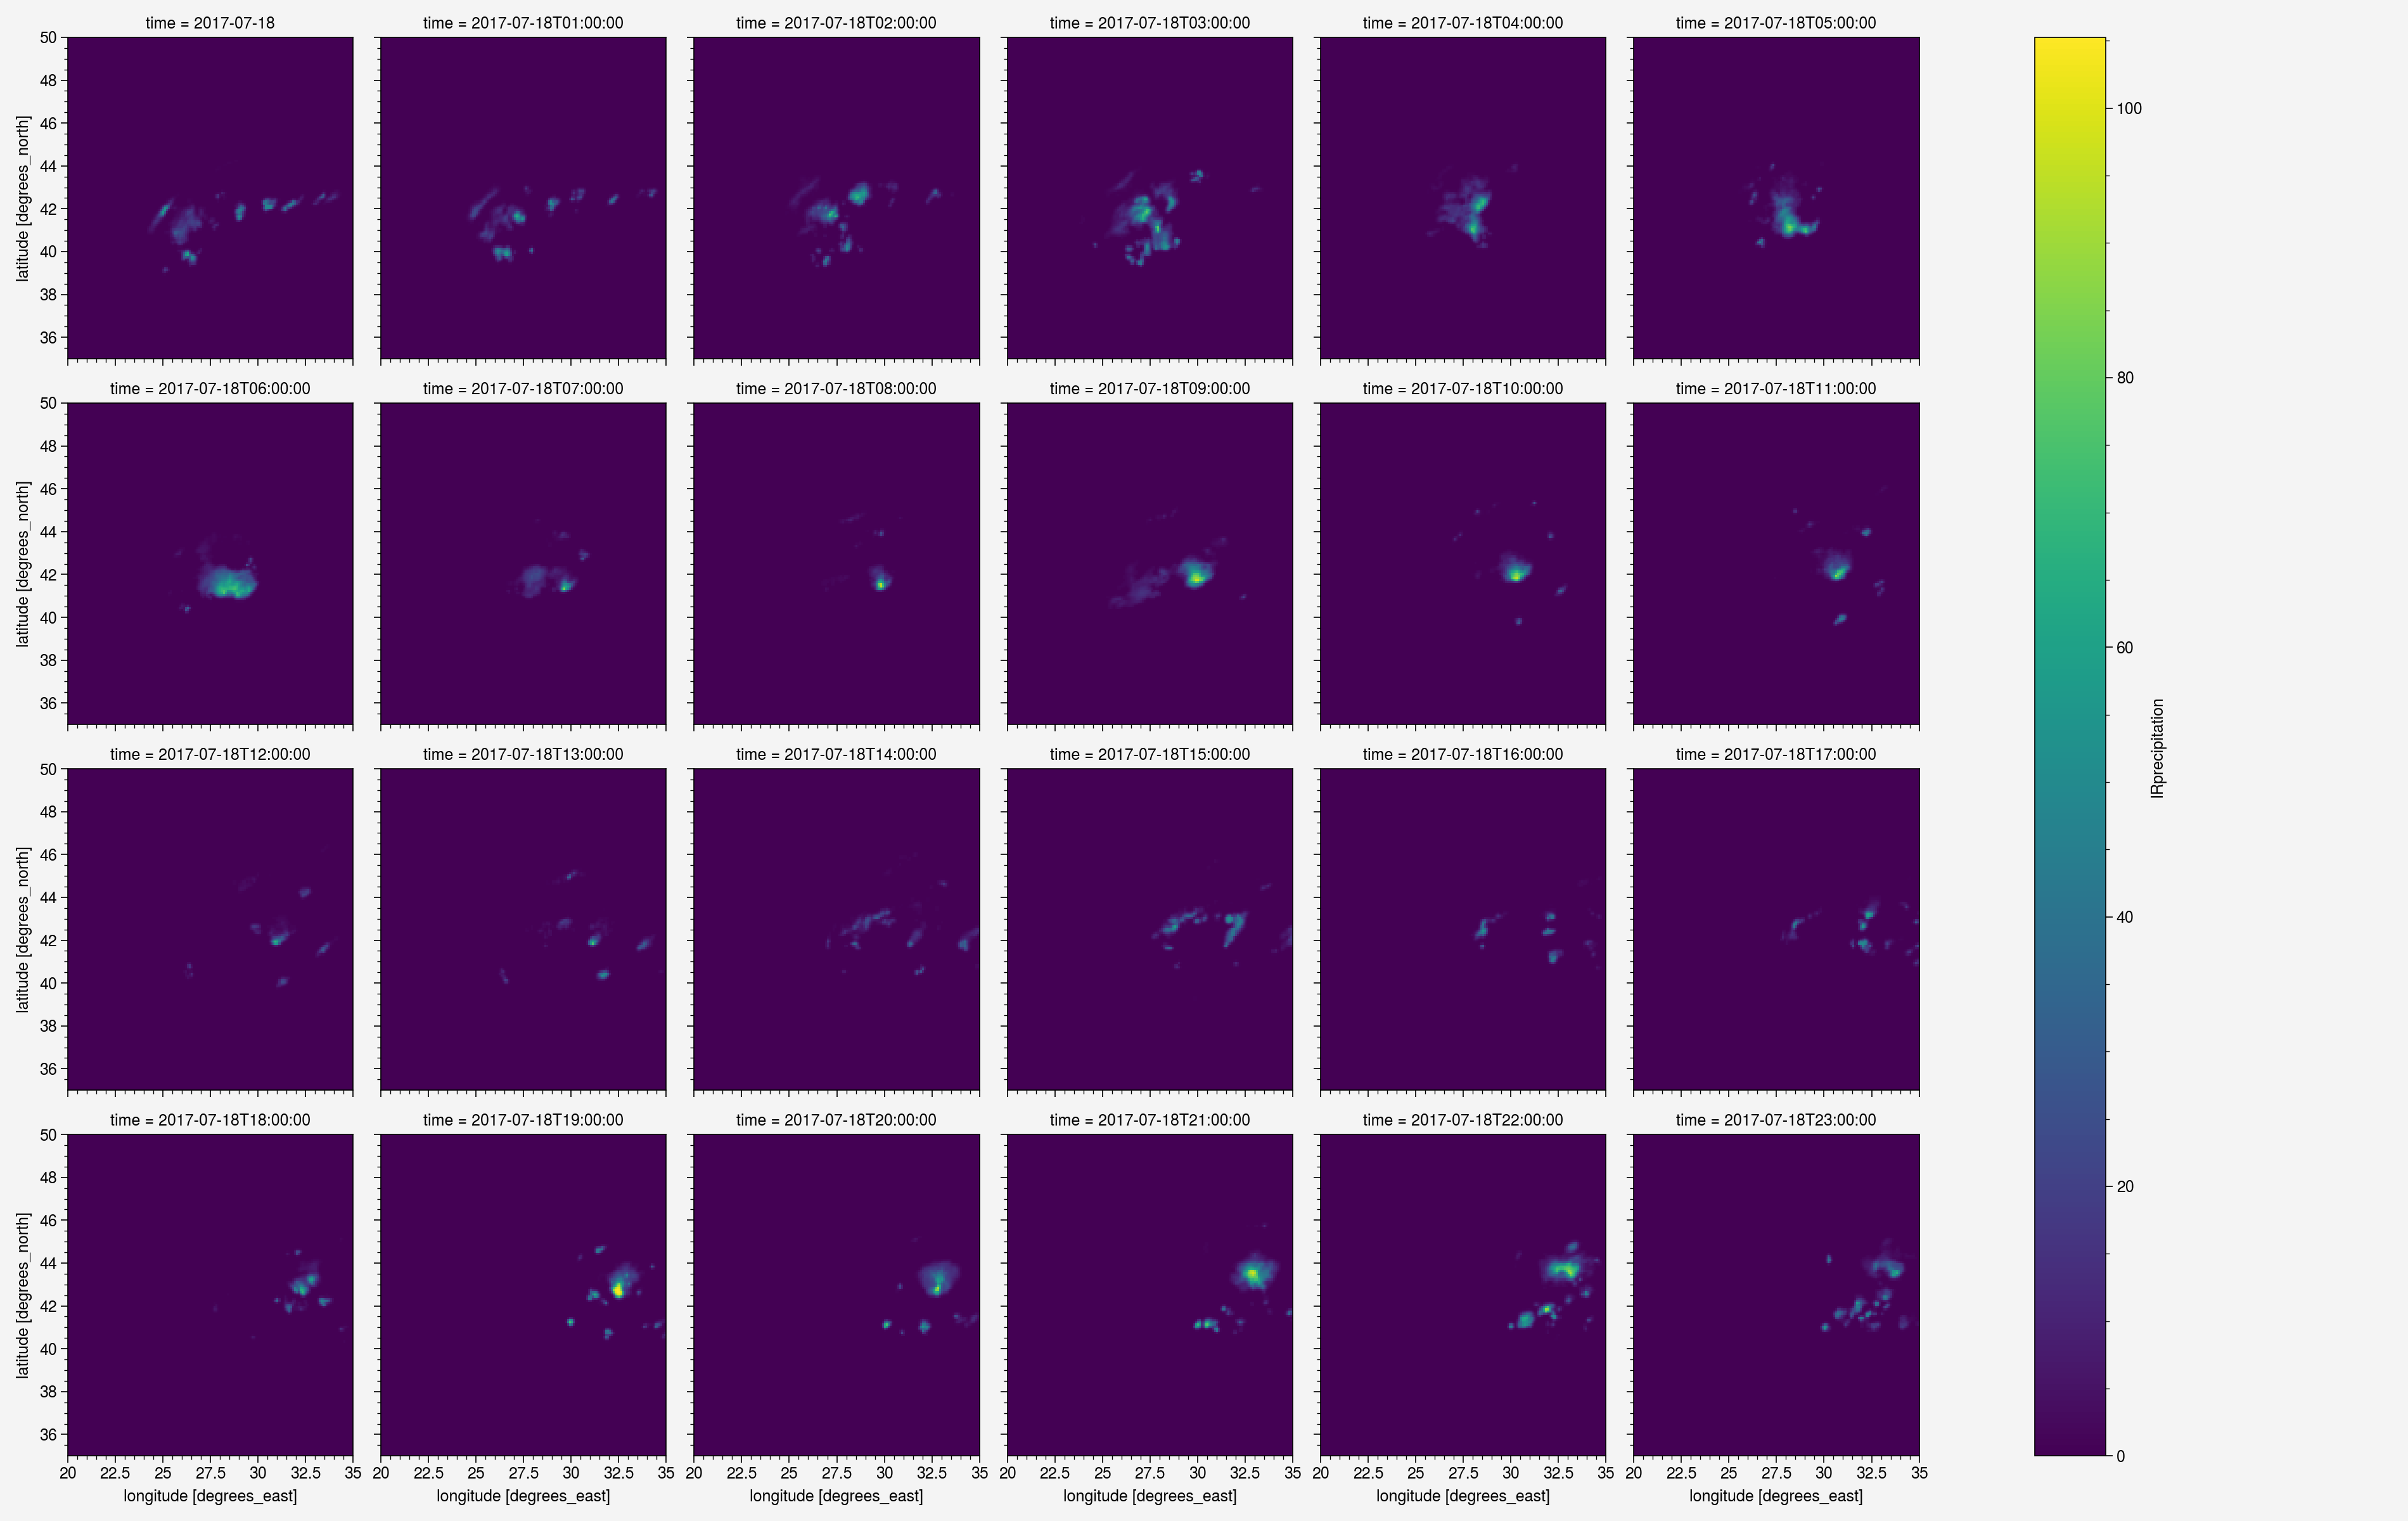

In [17]:
imerg.plot(col='time', col_wrap=6)

## 3. Plot

### 3.1 Options

In [18]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'data/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

In [19]:
# cmap for total urban and nourban hourly precipitation
nws_precip_colors_total = [
    "#FFFFFF",
    "#a9dff9",
    "#8acef5",
    "#67aae1", 
    "#4aa77a", 
    "#a2cf5a", 
    "#fed755", 
    "#f29a3e", 
    "#ef6934",
    "#cf212a"]
cmap = ListedColormap(nws_precip_colors_total)

In [20]:
# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_without_districts.shp'
turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

In [21]:
# Parameters to change (plot) -------------------
# projection
proj = dt_era5_urban_ens.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2, 3, 4, 5, 6, 7],
             [8, 9, 10, 11, 12, 13, 14],
             [15, 16, 17, 18, 19, 20, 21]
            ]
graphic_no = 21

# graphic vmin, vmax and norms
clevs_total = [0, 9, 18, 27, 36, 45, 63, 90, 117, 144, 180]
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = clevs_total

### 3.2 Graphic

In [24]:
def plot_hourly_spatial_plot(dt_plt, dt_name):
    
    # Create Figure -------------------------
    fig, axs = proplot.subplots(fig_array, 
                                aspect=4,
                                axwidth=2,
                                proj=lcc,
                                hratios=tuple(np.ones(len(fig_array), dtype=int)),
                                includepanels=True,
                                hspace=0.36,
                                wspace=0.36,
                                sharey=0)

    # format whole figure
    #axs.format(abcloc='ul',
    #       abc=True,)

    # istanbul limits
    axs.format(lonlim=(27.69171143+0.10, 30.04271274),
               latlim=(40.08444595+0.60, 41.88309609-0.20), 
               labels=False, 
               longrid=False, 
               latgrid = False)

    # add shapefiles
    shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                                 cartopy.crs.PlateCarree(), facecolor='none',
                                                 edgecolor = 'black', linewidth = 0.5, zorder = 0.5)

    shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                                 cartopy.crs.PlateCarree(), facecolor='none',
                                                 edgecolor = 'black', linewidth = 0.2, zorder = 0.4)

    for i in range(graphic_no):
        axs[i].add_feature(shape_district_turkey)
        axs[i].add_feature(shape_province_turkey)   

    # graphics
    dt_border = urban_luse_border
    for t in range(graphic_no):

        mesh = axs[t].pcolormesh(dt_plt['lon'], 
                                dt_plt['lat'],
                                dt_plt[t], 
                                cmap = cmap,
                                norm=norm,
                                zorder = 0.2,
                                alpha=0.8,
                                #extend = 'max'
                                )


        contour = axs[t].contour(dt_border['lon'], 
                                dt_border['lat'],
                                dt_border,
                                linewidth = 0.2
                                )

        axs[t].format(ultitle=fr"{t}", titlesize=18)

    # colorbar
    cbar = fig.colorbar(mesh,
                        label='mm/hr',
                        ticks = ticks,
                        loc = 'b',
                        shrink = 0.4,
                        width = 0.15,
                        labelsize = 18,
                         ticklabelsize = 18,
                        #extend = 'max'
                        #col=2
                       )

    #save figure
    plt.savefig(fr'pictures/verification_24_hourly_{dt_name}.jpeg',
                bbox_inches='tight', optimize=True,
                progressive=True, dpi=1000)

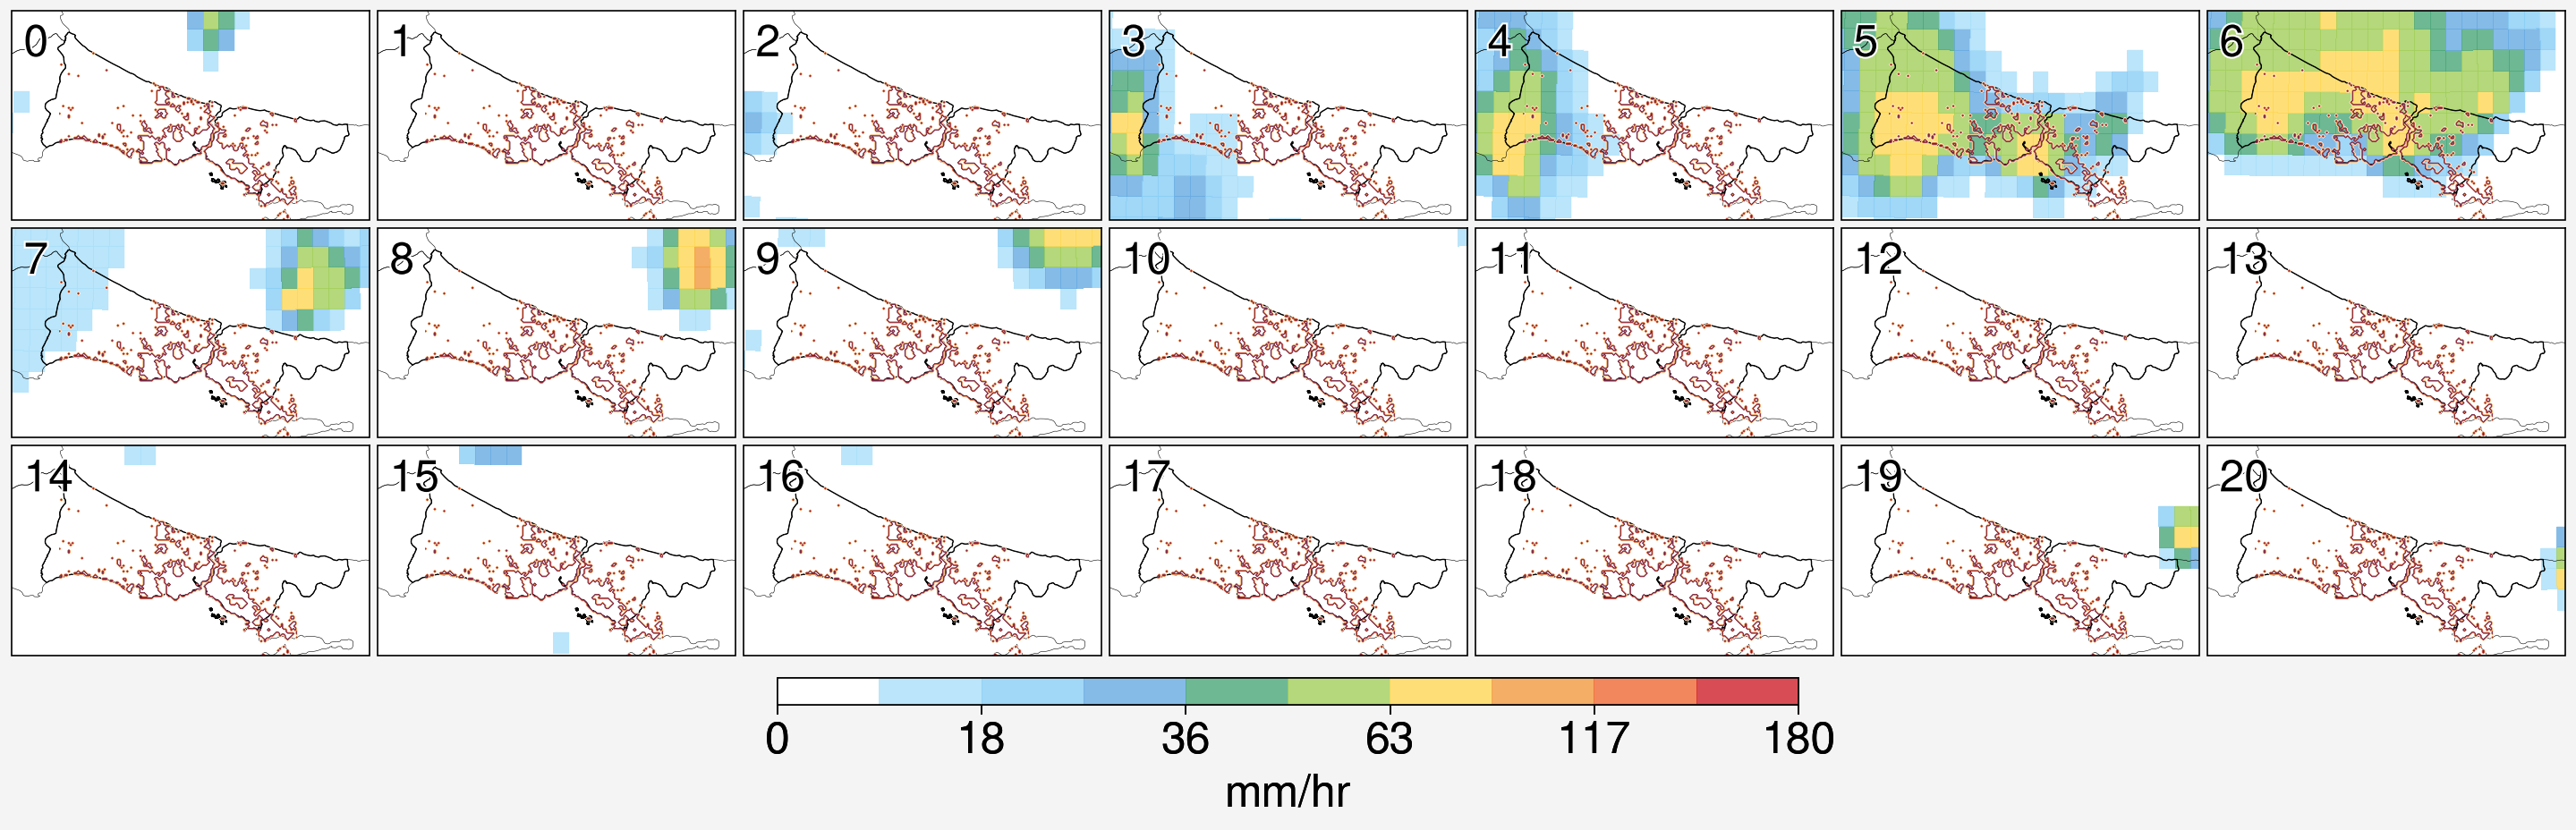

In [25]:
dt_plt = imerg
dt_name = 'imerg'

plot_hourly_spatial_plot(dt_plt, dt_name)

##### 3.2.1 Figure S8

In [ ]:
dt_plt = dt_era5_urban_ens
dt_name = 'era5'

plot_hourly_spatial_plot(dt_plt, dt_name)

##### 3.2.2 Figure S9

In [ ]:
dt_plt = dt_gfs_urban_ens
dt_name = 'gfs'

plot_hourly_spatial_plot(dt_plt, dt_name)